## 1. Обработка датасета

импортируем нужные библиотеки все тип

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [3]:
#df = pd.read_csv('cian_flats.csv')
df = pd.read_csv('cian_with_kindergartens.csv')
df.head()

,url,title,price,address,area,floor,year,metro_name,metro_time,house_type,_error,lat,lon,schools_count_800m,clinics_count_800m,kindergartens_count_800m
0,https://www.cian.ru/sale/flat/323603252/,"Продается 3-комн. квартира, 439 м²",1 528 010 000 ₽,"Москва, ЦАО, р-н Хамовники, 3-й Обыденский пер...",439 м²,1 из 6,NaN,Кропоткинская,5 мин.,Монолитный,NaN,55.742835,37.604031,8,10,3
1,https://www.cian.ru/sale/flat/322592319/,"Продается 2-комн. квартира, 47 м²",33 900 000 ₽,"Москва, ЦАО, р-н Пресненский, Зоологическая ул...",47 м²,5 из 10,1971.0,Баррикадная,7 мин.,NaN,NaN,55.764647,37.580769,4,20,11
2,https://www.cian.ru/sale/flat/322116585/,"Продается 5-комн. квартира, 227 м²",92 000 000 ₽,"Москва, СЗАО, р-н Щукино, ул. Маршала Конева, 14",227 м²,2 из 27,2010.0,Октябрьское поле,5 мин.,Монолитный,NaN,55.795938,37.485537,5,7,10
3,https://www.cian.ru/sale/flat/310065847/,"Продается 2-комн. квартира, 100,2 м²",340 680 000 ₽,"Москва, ЦАО, р-н Арбат, Никитский бул., 6/20","100,2 м²",5 из 8,NaN,Арбатская,3 мин.,NaN,NaN,55.753875,37.600625,11,30,6
4,https://www.cian.ru/sale/flat/321742080/,"Продается многокомнатная квартира, 584 м²",1 134 184 800 ₽,"Москва, ЦАО, р-н Хамовники, Молочный пер., 7",584 м²,5 из 6,2006.0,Парк Культуры,8 мин.,Монолитный,NaN,55.739415,37.601464,8,7,3


В нашем датасете много NaN, поэтому самое время от них избавиться! Для начала удалим колонку "error". Так же нас не интересуют строчки, где NaN в колонках 'price' и 'address'

In [4]:
if '_error' in df.columns:
    df = df.drop(columns=['_error'])

df = df.dropna(subset=['price', 'address'])

df = df.reset_index(drop=True)

df.isna().sum()

url                            0
title                          0
price                          0
address                        0
area                          33
floor                         35
year                        7576
metro_name                    87
metro_time                    87
house_type                  4598
lat                            0
lon                            0
schools_count_800m             0
clinics_count_800m             0
kindergartens_count_800m       0
dtype: int64

Избавимся от "Р" в цене

In [5]:
def clean_price(x):
    if pd.isna(x):
        return np.nan
    s = re.sub(r'[^\d\s]', '', str(x))
    s = re.sub(r'\s+', '', s) 
    try:
        v = int(s)
        if v > 1_000_000_000:  
            v //= 1000
        return v
    except:
        return np.nan

df['price'] = df['price'].apply(clean_price)
print(df['price'].describe())

count    1.859900e+04
mean     4.571575e+07
std      8.532279e+07
min      8.500000e+05
25%      1.499000e+07
50%      2.190000e+07
75%      3.656147e+07
max      1.000000e+09
Name: price, dtype: float64


Подкорректируем метры

In [6]:
df['area'] = (df['area'].astype(str)
              .str.replace('\xa0', ' ', regex=False) 
              .str.replace('\u2009', '', regex=False) 
             )

num = df['area'].str.extract(r'(\d+(?:[.,]\d+)?)', expand=False)
df['area'] = pd.to_numeric(num.str.replace(',', '.', regex=False), errors='coerce')
df = df.reset_index(drop=True)


Посмотрим на колонкы

In [7]:
df['area'].describe()

count    18566.000000
mean        70.761387
std         55.843670
min          1.000000
25%         40.000000
50%         57.100000
75%         78.900000
max        980.000000
Name: area, dtype: float64

In [8]:
df['price']

0          1528010
1         33900000
2         92000000
3        340680000
4          1134184
           ...    
18594     35950000
18595     21300000
18596     38000000
18597      9500000
18598     23986000
Name: price, Length: 18599, dtype: int64

## 2. Анализ данных

Для удобства создадим шкалу цены в миллионах

In [9]:
df['price_mln'] = (df['price'] / 1_000_000).round(2)

print(df[['price', 'price_mln']].head(10))

       price  price_mln
0    1528010       1.53
1   33900000      33.90
2   92000000      92.00
3  340680000     340.68
4    1134184       1.13
5   47000000      47.00
6   17950000      17.95
7   21900000      21.90
8   11100000      11.10
9   43587527      43.59


***Найдем цену за квадратный метр***! Но в 'area' 33 NaN, поэтому дропним их аккуратненько

In [10]:
df = df.dropna(subset=['area'])
df.head(3)

,url,title,price,address,area,floor,year,metro_name,metro_time,house_type,lat,lon,schools_count_800m,clinics_count_800m,kindergartens_count_800m,price_mln
0,https://www.cian.ru/sale/flat/323603252/,"Продается 3-комн. квартира, 439 м²",1528010,"Москва, ЦАО, р-н Хамовники, 3-й Обыденский пер...",439.0,1 из 6,NaN,Кропоткинская,5 мин.,Монолитный,55.742835,37.604031,8,10,3,1.53
1,https://www.cian.ru/sale/flat/322592319/,"Продается 2-комн. квартира, 47 м²",33900000,"Москва, ЦАО, р-н Пресненский, Зоологическая ул...",47.0,5 из 10,1971.0,Баррикадная,7 мин.,NaN,55.764647,37.580769,4,20,11,33.90
2,https://www.cian.ru/sale/flat/322116585/,"Продается 5-комн. квартира, 227 м²",92000000,"Москва, СЗАО, р-н Щукино, ул. Маршала Конева, 14",227.0,2 из 27,2010.0,Октябрьское поле,5 мин.,Монолитный,55.795938,37.485537,5,7,10,92.00


In [11]:
df['price_per_m2_mln'] = (df['price_mln'] / df['area']).round(4)
df['price_per_m2_mln'].describe(percentiles=[.1, .25, .5, .75, .9])

count    18566.000000
mean         0.689152
std         11.596389
min          0.001600
10%          0.271100
25%          0.322250
50%          0.413300
75%          0.557000
90%          0.843800
max        900.000000
Name: price_per_m2_mln, dtype: float64

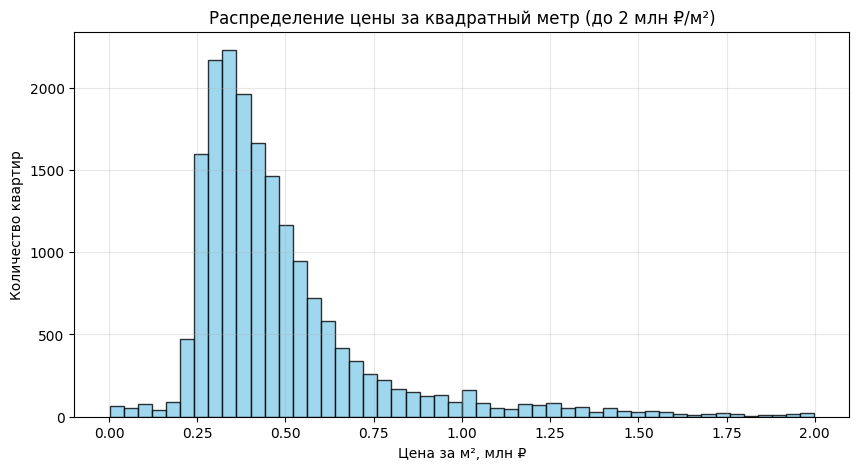

In [12]:
df_filtered = df[(df['price_per_m2_mln'] > 0) & (df['price_per_m2_mln'] < 2)]

plt.figure(figsize=(10,5))
plt.hist(
    df_filtered['price_per_m2_mln'], 
    bins=50, 
    color='skyblue', 
    edgecolor='black', 
    alpha=0.8
)
plt.title('Распределение цены за квадратный метр (до 2 млн ₽/м²)')
plt.xlabel('Цена за м², млн ₽')
plt.ylabel('Количество квартир')
plt.grid(alpha=0.3)
plt.show()

Теперь проведем ***анализ по метро***!

Посмотрим на самые частые ближайшие станции

In [13]:
df['metro_name'].value_counts().head(10)


metro_name
Сокол                    425
Бульвар Рокоссовского    366
Аэропорт                 362
Арбатская                357
Ботанический сад         333
Алексеевская             312
Селигерская              302
Медведково               291
Грачёвская               290
Смоленская               285
Name: count, dtype: int64

Найдем среднюю цену по станциям

In [14]:
df_valid = df[(df['price_per_m2_mln'] > 0) & (df['price_per_m2_mln'] < 2)]

metro_stats = (
    df_valid.groupby('metro_name')['price_per_m2_mln']
    .agg(['median', 'count'])
    .sort_values('median', ascending=False)
)

metro_stats = metro_stats[metro_stats['count'] > 10]
print(metro_stats.head(10))


                  median  count
metro_name                     
Полянка          1.31560     39
Охотный ряд      1.24215     12
Улица 1905 года  1.24060     47
Деловой центр    1.18460     50
Парк Победы      1.17140     25
Арбатская        1.16320    282
Новокузнецкая    1.15330    113
Фрунзенская      1.11930     34
Парк Культуры    1.07000     47
Тверская         1.05750     23


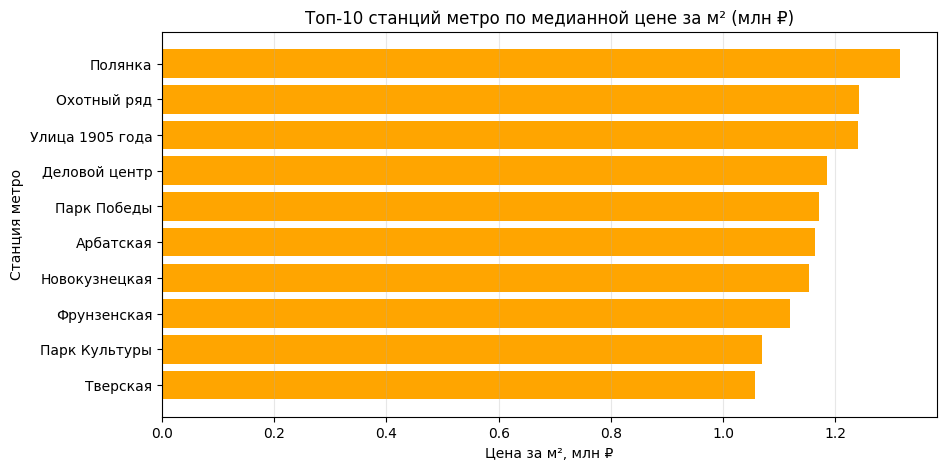

In [15]:
top10 = metro_stats.head(10)

plt.figure(figsize=(10,5))
plt.barh(top10.index[::-1], top10['median'][::-1], color='orange')
plt.title('Топ-10 станций метро по медианной цене за м² (млн ₽)')
plt.xlabel('Цена за м², млн ₽')
plt.ylabel('Станция метро')
plt.grid(axis='x', alpha=0.3)
plt.show()


Теперь обратим внимание на ***тип дома***

In [16]:
df['house_type'].value_counts()

house_type
Монолитный             5312
Панельный              3351
Кирпичный              3108
Монолитно-кирпичный    1279
Блочный                 919
Сталинский               29
Деревянный                3
Name: count, dtype: int64

In [17]:
df.groupby('house_type')['price_per_m2_mln'].mean().sort_values(ascending=False)

house_type
Монолитный             1.023172
Кирпичный              0.801883
Монолитно-кирпичный    0.730547
Сталинский             0.390962
Блочный                0.364158
Панельный              0.313911
Деревянный             0.305867
Name: price_per_m2_mln, dtype: float64

Сделаем график, на котором покажем среднюю цену за м² по типу дома и станции метро (в млн ₽)

/opt/homebrew/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8381 (\N{RUBLE SIGN}) missing from font(s) Arial.
  fig.canvas.draw()
/var/folders/mp/vpb2q94j1nx2x6d9938tq75m0000gn/T/ipykernel_90661/1817507660.py:57: UserWarning: Glyph 8381 (\N{RUBLE SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/Users/alexandr/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8381 (\N{RUBLE SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


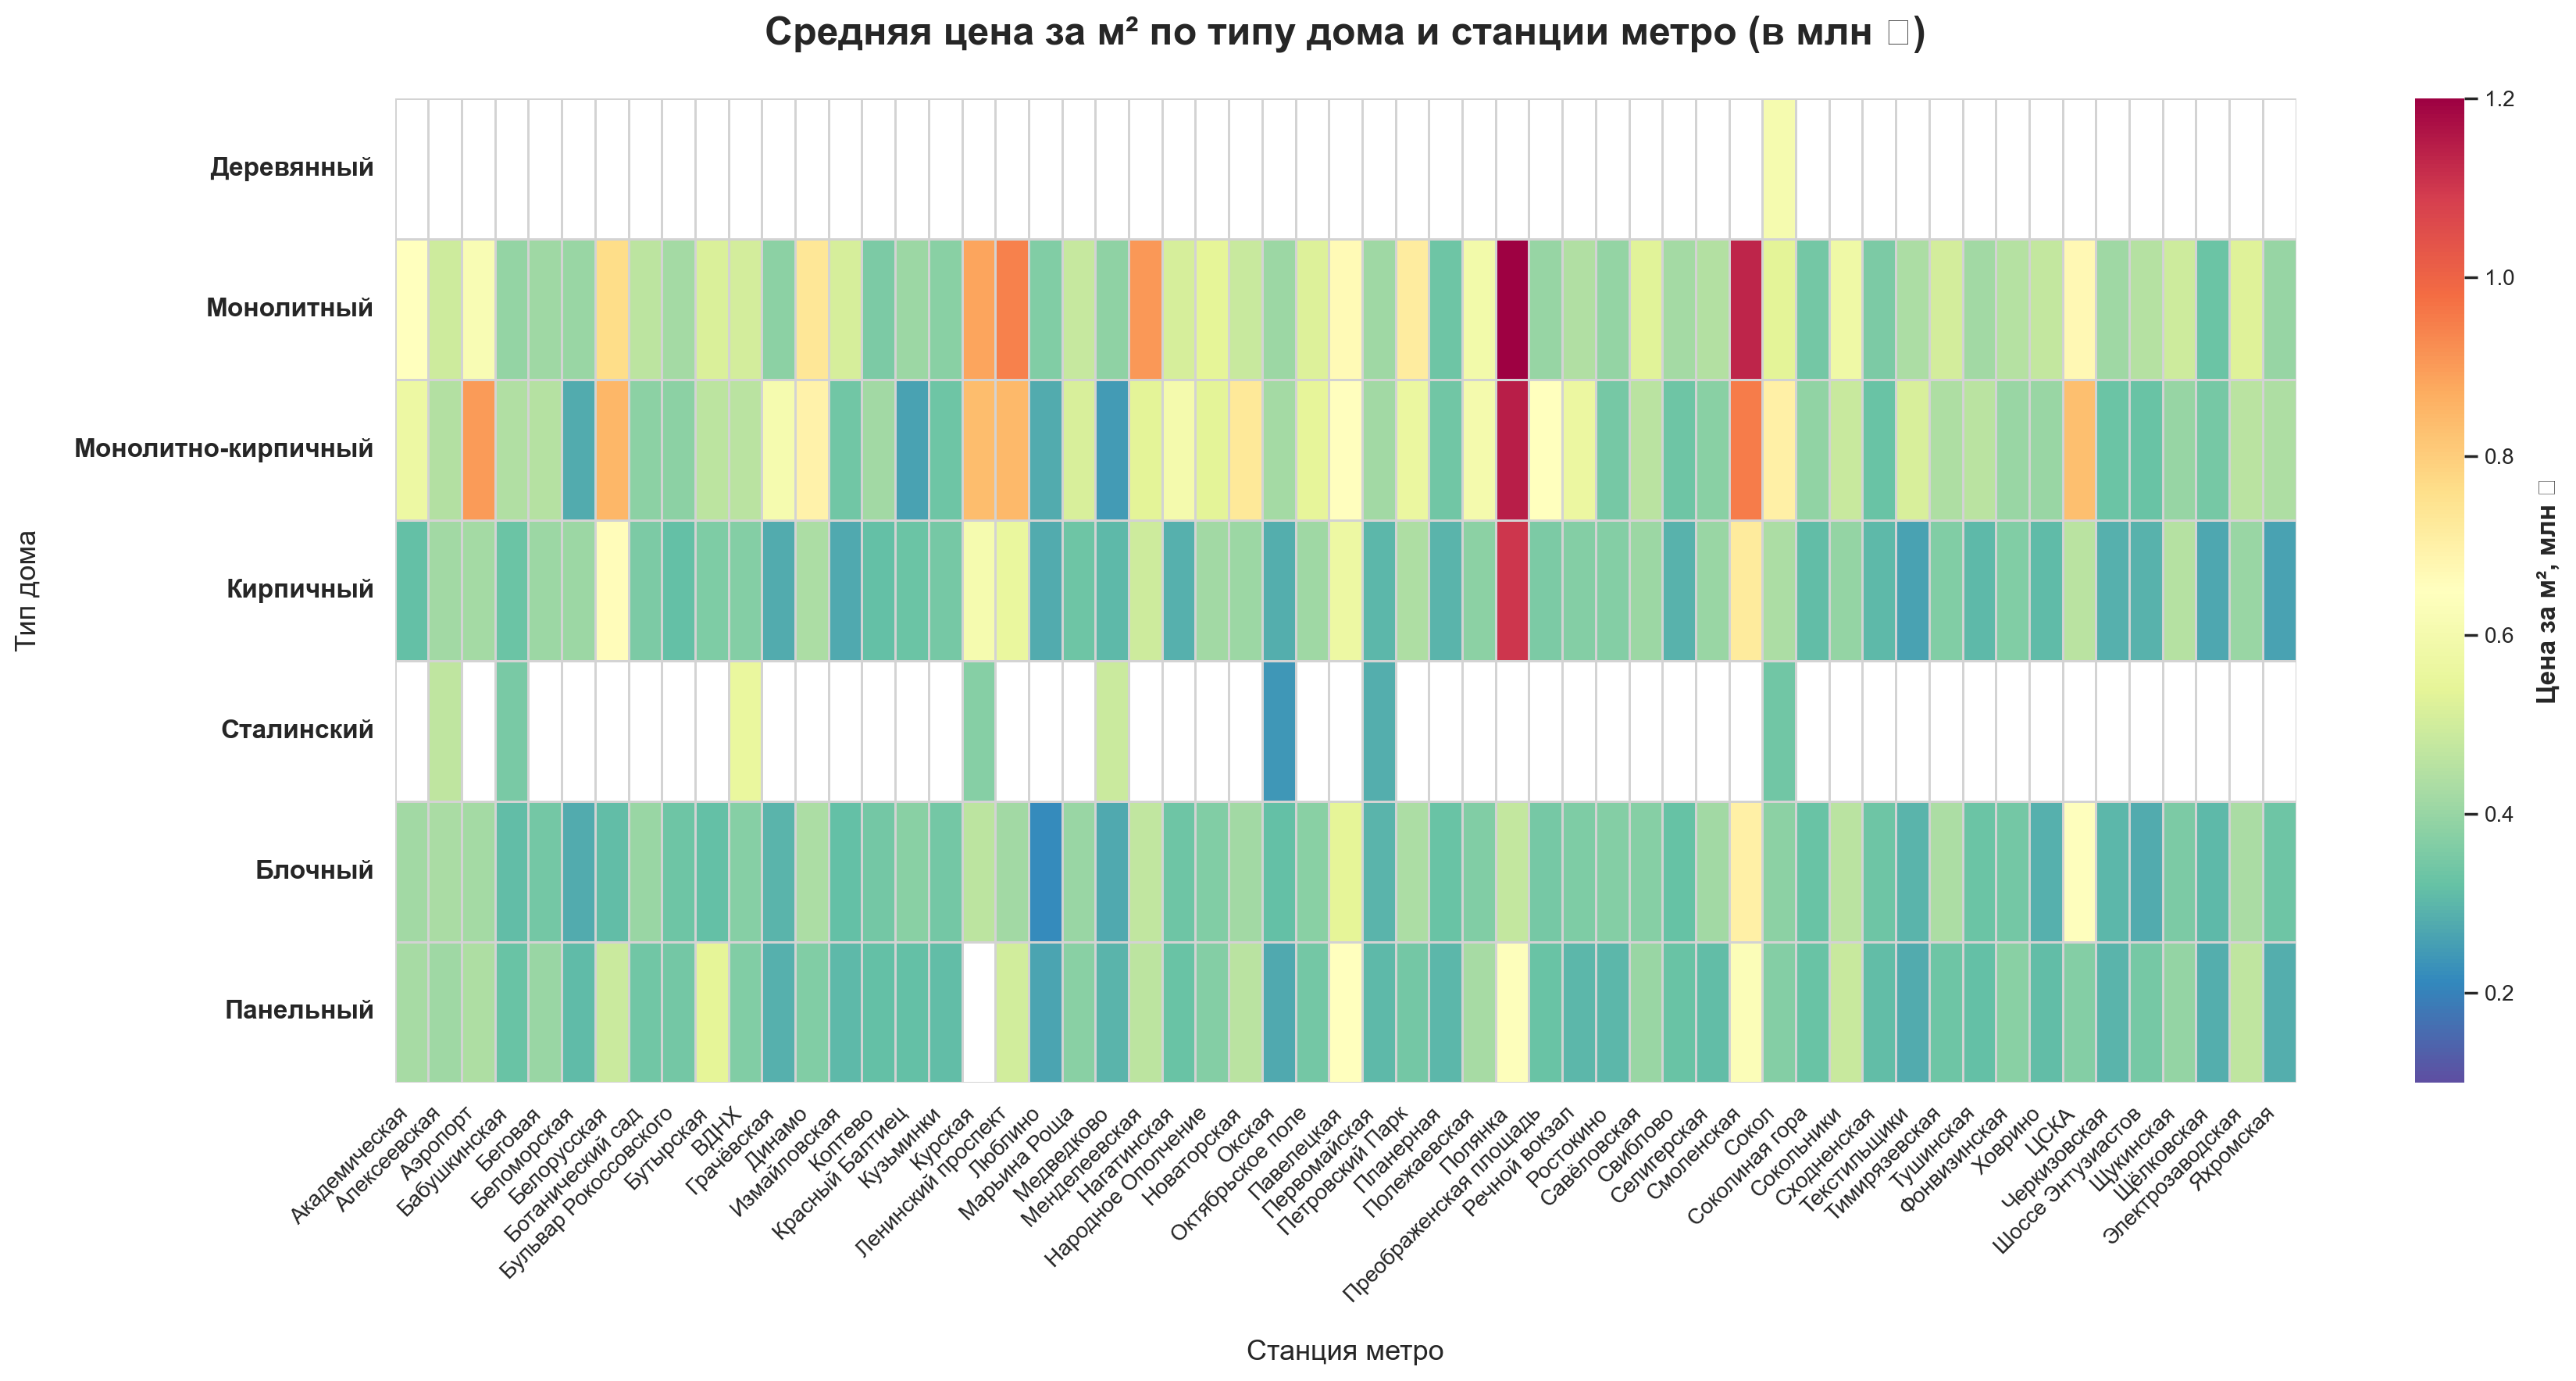

In [18]:
df_heat = df[(df['price_per_m2_mln'] > 0) & (df['price_per_m2_mln'] < 1.5)]

pivot = (
    df_heat.pivot_table(
        values='price_per_m2_mln',
        index='house_type',
        columns='metro_name',
        aggfunc='mean'
    )
)

pivot = pivot.dropna(thresh=5, axis=1)

pivot = pivot.loc[pivot.mean(axis=1).sort_values(ascending=False).index]

sns.set_theme(style='white')
plt.figure(figsize=(18, 9), dpi=200)

ax = sns.heatmap(
    pivot,
    cmap='Spectral_r',         
    linewidths=0.5,
    linecolor='lightgray',
    cbar=True,
    cbar_kws={'label': 'Цена за м², млн ₽'},
    square=False,
    vmin=0.1,
    vmax=1.2,
)

plt.title(
    "Средняя цена за м² по типу дома и станции метро (в млн ₽)",
    fontsize=18,
    weight='bold',
    pad=25,
)
plt.xlabel("Станция метро", fontsize=13, labelpad=15)
plt.ylabel("Тип дома", fontsize=13, labelpad=15)

plt.xticks(
    rotation=45, 
    ha='right', 
    fontsize=10, 
    fontweight='medium'
)
plt.yticks(
    fontsize=12, 
    fontweight='bold', 
    rotation=0
)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Цена за м², млн ₽', fontsize=12, fontweight='bold', labelpad=10)

plt.grid(False)
plt.tight_layout()
plt.show()


Введем ***год постройки***!

In [123]:
df['year'].describe()


count    11030.000000
mean      1991.147053
std         30.692969
min       1793.000000
25%       1968.250000
50%       2000.000000
75%       2020.000000
max       2027.000000
Name: year, dtype: float64

Цена за м² по году постройки (млн ₽) — медиана и интерквартильный диапазон

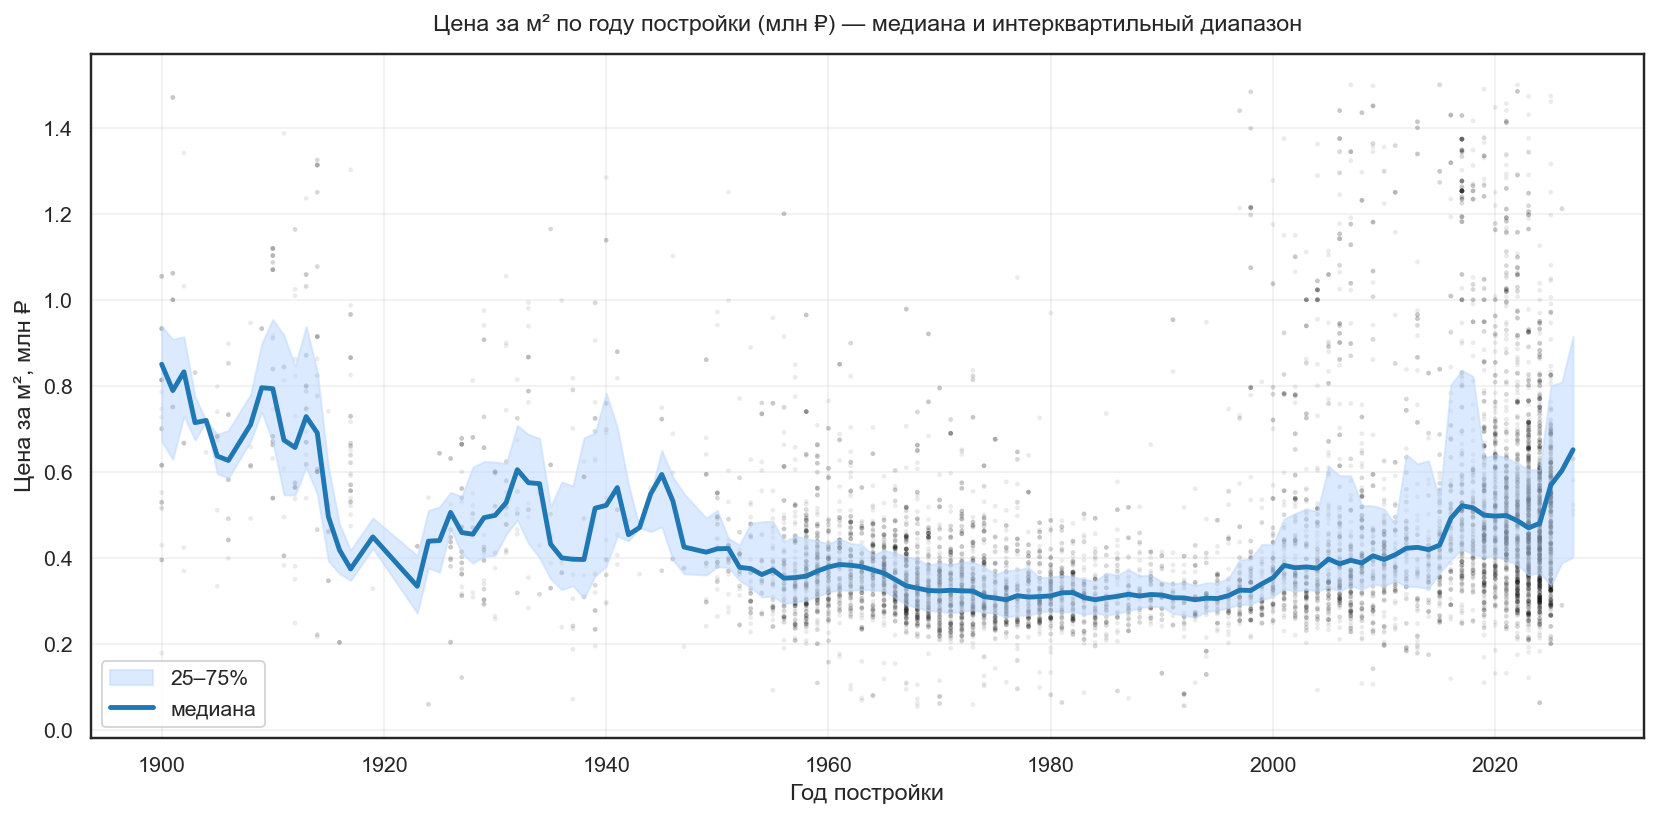

In [ ]:
d = df.copy()
d['year'] = pd.to_numeric(d['year'], errors='coerce')
d['price_per_m2_mln'] = pd.to_numeric(d['price_per_m2_mln'], errors='coerce')

d = d[
    d['year'].between(1900, 2027) &
    d['price_per_m2_mln'].between(0.05, 1.5) &
    d['area'].between(10, 400)
].copy()

year_stats = (
    d.groupby('year')['price_per_m2_mln']
     .agg(median='median', q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75), n='count')
     .reset_index()
)

year_stats['median_smooth'] = year_stats['median'].rolling(window=3, center=True, min_periods=1).mean()
year_stats['q25_smooth']    = year_stats['q25'].rolling(window=3, center=True, min_periods=1).mean()
year_stats['q75_smooth']    = year_stats['q75'].rolling(window=3, center=True, min_periods=1).mean()

plt.figure(figsize=(12,6), dpi=140)

plt.scatter(d['year'], d['price_per_m2_mln'], s=6, alpha=0.08, color='black', edgecolors='none')

plt.fill_between(year_stats['year'], year_stats['q25_smooth'], year_stats['q75_smooth'],
                 color='#BBD7FF', alpha=0.5, label='25–75%')

plt.plot(year_stats['year'], year_stats['median_smooth'], color='#1f77b4', linewidth=2.5, label='медиана')

plt.title('Цена за м² по году постройки (млн ₽) — медиана и интерквартильный диапазон', pad=12)
plt.xlabel('Год постройки')
plt.ylabel('Цена за м², млн ₽')
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

Теперь найдем зависимость между ***ценой за м² и ценой за минуту до метро***. 

Но для начала посмотрим просто на график цены за минуту

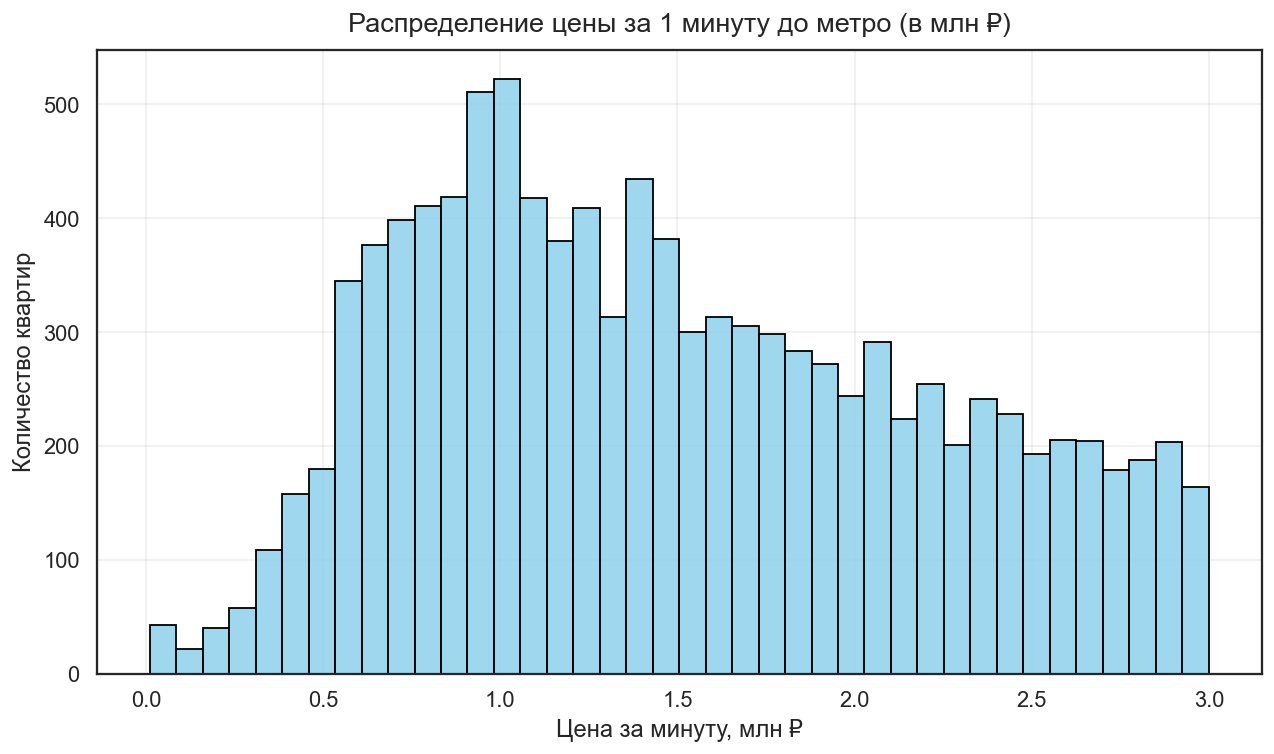

In [150]:
df_plot = df.copy()

if 'price_mln' not in df_plot.columns:
    df_plot['price_mln'] = pd.to_numeric(df_plot['price'], errors='coerce') / 1_000_000

df_plot['metro_time'] = (
    df_plot['metro_time'].astype(str).str.extract(r'(\d+)').astype(float)
)

df_plot['price_per_min'] = df_plot['price_mln'] / df_plot['metro_time']
df_plot = df_plot.replace([np.inf, -np.inf], np.nan)
df_plot = df_plot[
    df_plot['price_per_min'].between(0.01, 200)
].dropna(subset=['price_per_min'])

plt.figure(figsize=(10,6), dpi=130)
sns.histplot(
    df_plot[df_plot['price_per_min'] < 3]['price_per_min'],  # только до 3 млн
    bins=40,
    color='skyblue',
    edgecolor='black',
    alpha=0.8
)
plt.title('Распределение цены за 1 минуту до метро (в млн ₽)', fontsize=15, pad=10)
plt.xlabel('Цена за минуту, млн ₽')
plt.ylabel('Количество квартир')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



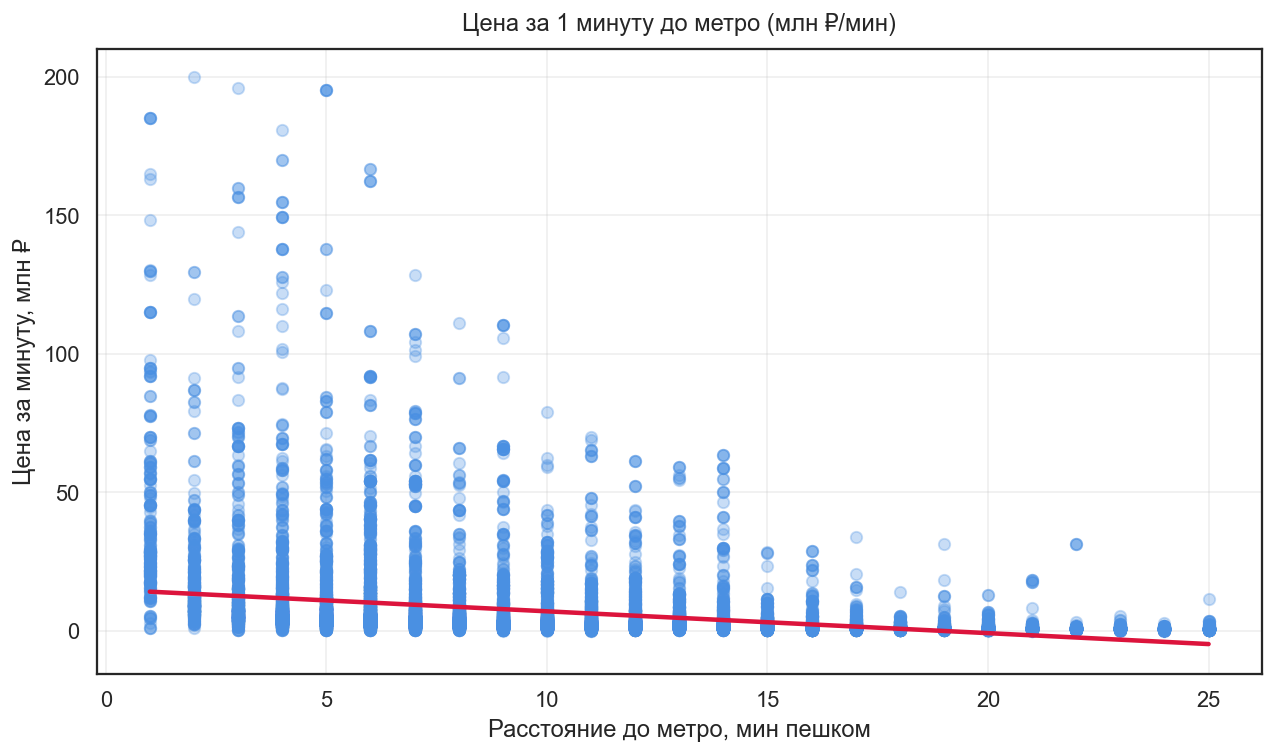

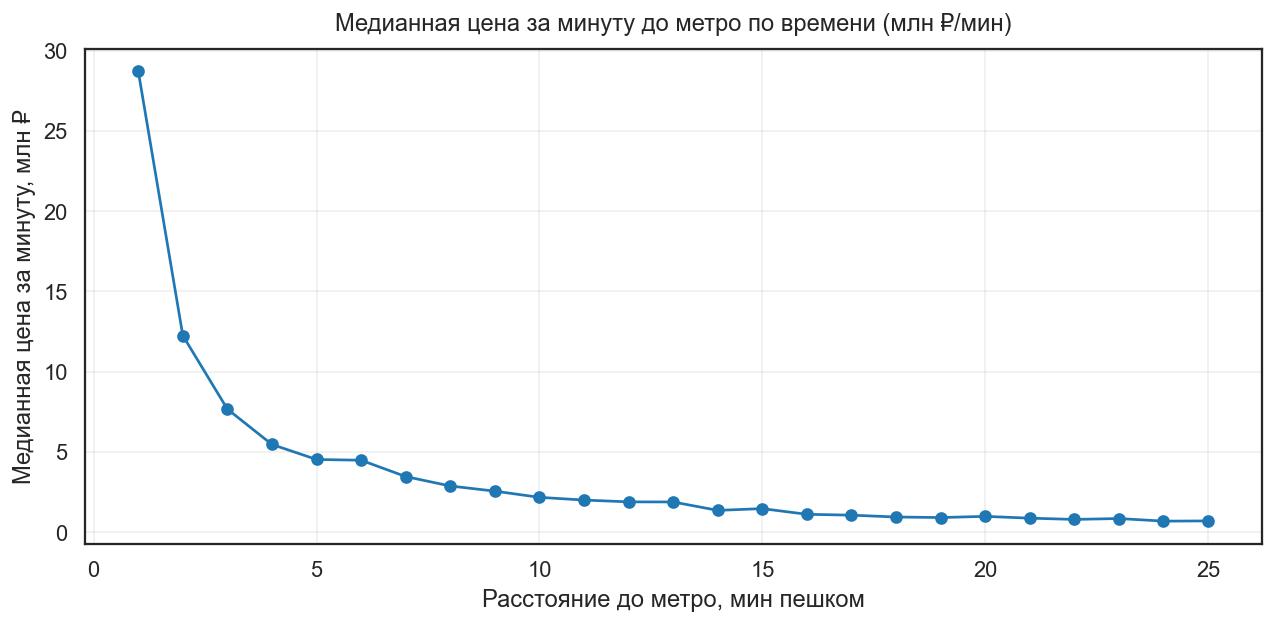

In [146]:
df_plot = df.copy()

# 1) Приводим время до метро к числу (минуты)
df_plot['metro_time'] = (
    df_plot['metro_time'].astype(str).str.extract(r'(\d+)').astype(float)
)

# 2) Убедимся, что есть цена в млн; если нет — посчитаем из 'price'
if 'price_mln' not in df_plot.columns:
    df_plot['price_mln'] = pd.to_numeric(df_plot['price'], errors='coerce') / 1_000_000

# 3) Цена за минуту до метро (в млн ₽/мин)
df_plot['price_per_min'] = df_plot['price_mln'] / df_plot['metro_time']
df_plot.replace([np.inf, -np.inf], np.nan, inplace=True)

# 4) Фильтры от мусора/выбросов
df_plot = df_plot[
    df_plot['metro_time'].between(1, 40) &          # 1–40 мин пешком
    df_plot['price_per_min'].between(0.01, 200)     # разумные рамки
].dropna(subset=['price_per_min'])

# ===== ГРАФИК 1: рассеяние + тренд =====
plt.figure(figsize=(10,6), dpi=130)
sns.regplot(
    data=df_plot,
    x='metro_time', y='price_per_min',
    scatter_kws={'alpha':0.3, 's':40, 'color':'#4a90e2'},
    line_kws={'color':'crimson', 'linewidth':2.5}
)
plt.title('Цена за 1 минуту до метро (млн ₽/мин)', pad=10)
plt.xlabel('Расстояние до метро, мин пешком')
plt.ylabel('Цена за минуту, млн ₽')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ===== ГРАФИК 2 (ещё нагляднее): медиана по каждой минуте =====
med = df_plot.groupby('metro_time')['price_per_min'].median().reset_index()

plt.figure(figsize=(10,5), dpi=130)
plt.plot(med['metro_time'], med['price_per_min'], marker='o', color='#1f77b4')
plt.title('Медианная цена за минуту до метро по времени (млн ₽/мин)', pad=10)
plt.xlabel('Расстояние до метро, мин пешком')
plt.ylabel('Медианная цена за минуту, млн ₽')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 3. Матрица корреляций

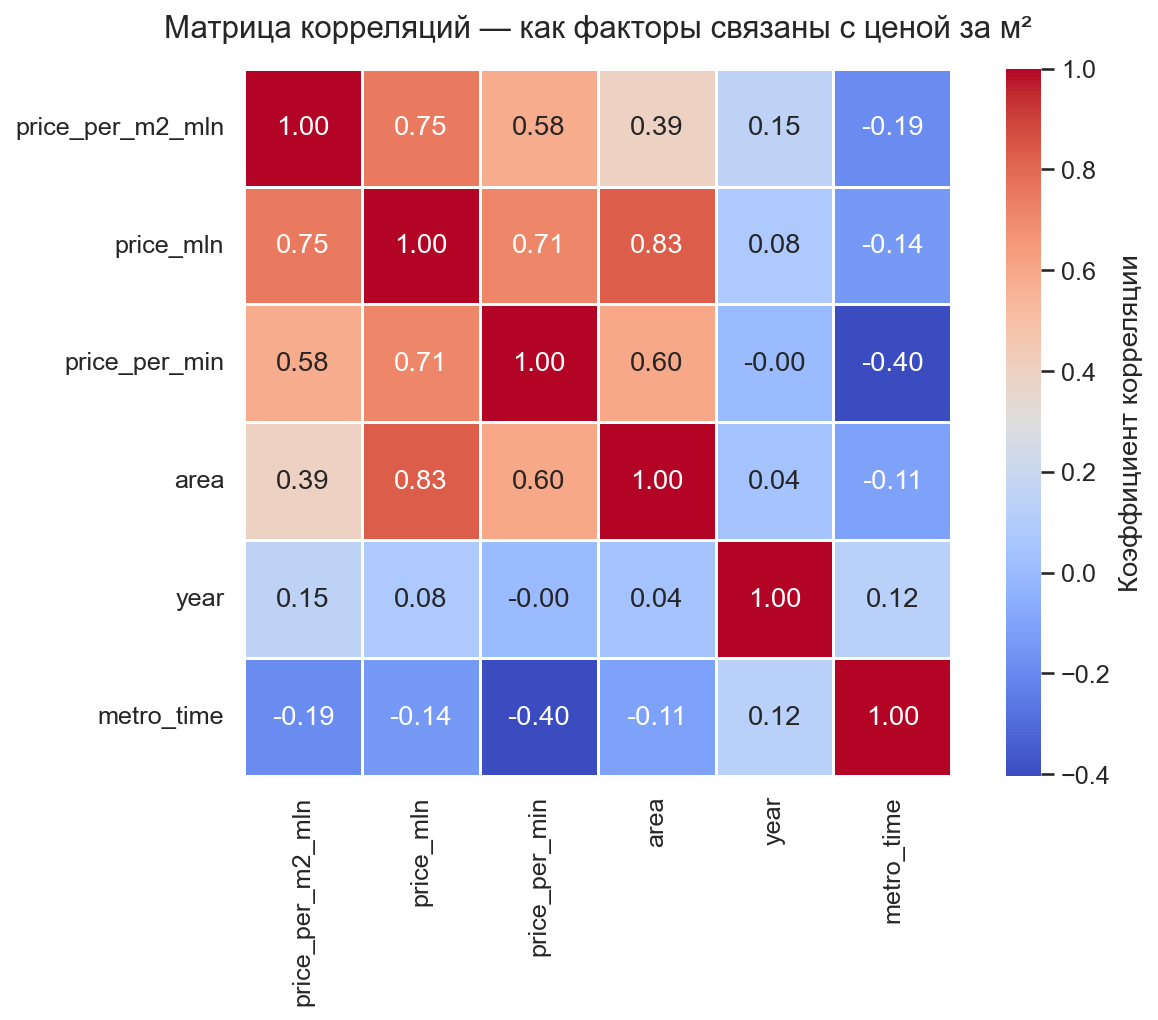

In [140]:
df_corr = df.copy()

df_corr['metro_time'] = (
    df_corr['metro_time']
    .astype(str)
    .str.extract(r'(\d+)')
    .astype(float)
)
for col in ['price_mln', 'price_per_m2_mln', 'area', 'year']:
    df_corr[col] = pd.to_numeric(df_corr[col], errors='coerce')

df_corr['price_per_min'] = df_corr['price_mln'] / df_corr['metro_time']

df_corr = df_corr[
    (df_corr['price_per_m2_mln'].between(0.05, 1.5)) &
    (df_corr['price_mln'].between(1, 500)) &
    (df_corr['area'].between(10, 400)) &
    (df_corr['year'].between(1900, 2027)) &
    (df_corr['metro_time'].between(1, 60))
].copy()

corr = df_corr[['price_per_m2_mln', 'price_mln', 'price_per_min', 'area', 'year', 'metro_time']].corr()

plt.figure(figsize=(9,7), dpi=150)
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=0.6,
    cbar_kws={'label': 'Коэффициент корреляции'},
    square=True
)
plt.title("Матрица корреляций — как факторы связаны с ценой за м²", fontsize=15, pad=15)
plt.tight_layout()
plt.show()

`1. price_per_m2_mln ↔ price_mln = 0.75`

— Естественная сильная связь: общая цена и цена за метр всегда растут вместе.
Чем дороже квартира, тем дороже квадратный метр.

`2. price_per_m2_mln ↔ price_per_min = 0.58`

— Значимая положительная корреляция:
чем дороже “минута до метро”, тем выше стоимость за метр.
Люди платят премию за близость — время = деньги.

`3. price_per_m2_mln ↔ area = 0.39`

— Умеренная связь: большие квартиры часто дороже в целом,
но метр в них стоит чуть дешевле. Это типичная рыночная закономерность:
у маленьких квартир “метр” дороже из-за общей доступности.

`4. price_per_m2_mln ↔ year = 0.15`

— Лёгкий плюс: новые дома чуть дороже,
но влияние не такое сильное, как у расстояния до метро.

`5. price_per_m2_mln ↔ metro_time = –0.19`

То, что нужно! Чёткая отрицательная зависимость:
чем дальше от метро, тем дешевле метр.
Почти линейная тенденция, но слабеет после 15–20 минут — рынок “успокаивается”.

## 4. ML-ка быстренька + ВЫВОДЫ

In [ ]:
df_ml = df[['price_per_m2_mln', 'area', 'year', 'metro_time']].copy()

df_ml['metro_time'] = (
    df_ml['metro_time'].astype(str).str.extract(r'(\d+)').astype(float)
)

for col in ['price_per_m2_mln', 'area', 'year']:
    df_ml[col] = pd.to_numeric(df_ml[col], errors='coerce')

df_ml = df_ml.replace([np.inf, -np.inf], np.nan)
df_ml = df_ml[
    df_ml['price_per_m2_mln'].between(0.05, 1.5) &
    df_ml['area'].between(10, 400) &
    df_ml['year'].between(1900, 2027) &
    df_ml['metro_time'].between(1, 60)
].dropna()


X = df_ml[['area', 'year', 'metro_time']]
y = df_ml['price_per_m2_mln']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print("R²:", round(r2_score(y_test, y_pred), 3))
print("MAE (млн ₽/м²):", round(mean_absolute_error(y_test, y_pred), 3))

coefs = pd.Series(pipe.named_steps['linreg'].coef_, index=X.columns).round(3)
print("\nКоэффициенты (влияние на цену за м²):")
print(coefs.sort_values(ascending=False))




R²: 0.206
MAE (млн ₽/м²): 0.144

Коэффициенты (влияние на цену за м²):
area          0.085
year          0.035
metro_time   -0.038
dtype: float64


***ВЫВОДЫ***

`Анализ цен и распределений`

Средняя цена за м² - около 0.25 млн. Распределение цен сильно смещено вправо - на рынке доминирует средняя и низкая стоимость. Премиум-сегмент (миллиард и выше) - редкость (1 млн ₽/м² и выше)

`Зависимость от факторов`

*Тип дома*. Самые дорогие - монолитные (≈1 млн ₽/м²),
дешевле всего - деревянные и панельные (~0.3 млн ₽/м²).

*Метро*. Чем ближе - тем дороже. Логично. 1 минута ходьбы в среднем на 30-40 тысяч повышает стоимость за м².

*Год постройки*. Чем новее дом - тем выше цена. После 2010 средняя ценаа м² растёт ускоренно.

`Самые важные выводы`

**Новое, ближе к метро, монолитное — значит дороже**